# 1. Fetching the data

In [271]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


In [272]:
import numpy as np
import matplotlib.pyplot as plt
# library required for scaling the data
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import warnings
import yfinance as yf
warnings.filterwarnings('ignore')

In [273]:
data = pd.read_csv('SBIN.csv', index_col=0,
                   parse_dates=True, na_values=0).dropna()

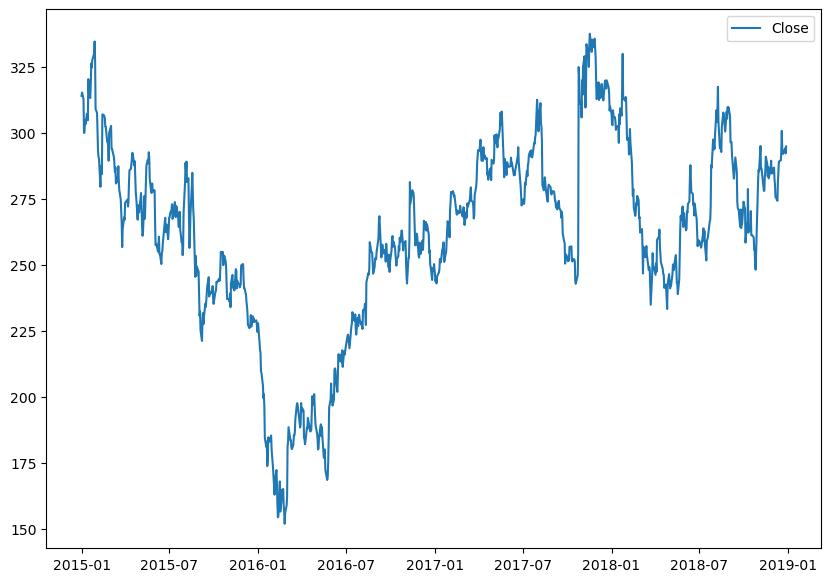

In [274]:
plt.figure(figsize=(10, 7))
plt.plot(data.Close)
plt.legend(['Close'])
plt.show()

# 2. Scaling the data

In [275]:
# Specify the test data size
test_size = 200

# To avoid any look forward bias we will be taking only the train data to scale the data
# Using .max() once gives the maximum values of each column
max_ = data.iloc[:-test_size][['Open', 'High', 'Low', 'Close']].max().max()
min_ = data.iloc[:-test_size][['Open', 'High', 'Low', 'Close']].min().min()
max_, min_

(351.3, 148.25)

In [276]:
X1 = (data[['Open', 'High', 'Low', 'Close']]-min_)/(max_-min_)
X1 = np.array(X1)

## 2.1 Scaling the volume 

In [277]:
# Here we will instantiate a Minmaxscaler function
# Then fit the Volume column data and transform it to the range of 0,1.
# Here we specify the shape of input as it is a single column, and sklearn expexcts you to explicyt
# reshape when input data is a single column
scl = MinMaxScaler()
scl.fit(data[['Volume']].iloc[:-test_size].values.reshape(-1, 1))
X2 = scl.transform(data[['Volume']].values.reshape(-1, 1))

In [278]:
data = data.assign(Open=X1[:, 0])
data = data.assign(High=X1[:, 1])
data = data.assign(Low=X1[:, 2])
data = data.assign(Close=X1[:, 3])
data = data.assign(Volume=X2[:, 0])
data.tail()

,Close,High,Low,Open,Volume,Last
Date,,,,,,
2018-12-21 00:00:00+00:00,0.707461,0.730116,0.702044,0.716080,0.052628,291.90
2018-12-24 00:00:00+00:00,0.713125,0.722728,0.698843,0.715341,0.038322,293.05
2018-12-26 00:00:00+00:00,0.718542,0.722728,0.684068,0.712140,0.040760,294.15
2018-12-27 00:00:00+00:00,0.708692,0.735533,0.705491,0.731101,0.050814,292.15
2018-12-28 00:00:00+00:00,0.721743,0.733071,0.715587,0.715834,0.041497,294.80


# 3. Creating feature and target datasets

In [279]:
# Step 1: Creation of Dataset X
X = data[['Open', 'High', 'Low', 'Close', 'Volume']]

In [280]:
# Step 2: Creation of Dataset y
# Here we first create a column of ones that has the same length as the dataframe 'data'.
# Later we will store the target values in this column.
# We have given the target of predicting the weekly returns' trend to our strategy.
# So the target variable will attempt to predict if the close price has increased or decreased after 5 trading days.
y = np.ones(len(data.Close))

# If the returns are higher, then 'y' is 1, else '0'.
y = np.where(data.Close > data.Close.shift(5), 1, 0)

In [281]:
# Step 3: Creation of 4 Datasets
X_train = np.array(X.iloc[5:-test_size])
y_train = np.array(y[5:-test_size])
X_test = np.array(X.iloc[-test_size:])
y_test = np.array(y[-test_size:])

# 4. Set Class Weights

In [282]:
class_1 = y_train.sum()
class_0 = len(y_train)-class_1

class_1, class_0

(381, 400)

In [283]:
class_0_percentage = class_0/len(y_train)
class_1_percentage = class_1/len(y_train)

class_0_weight = class_1_percentage
class_1_weight = class_0_percentage

# We will create a dictionary called class_weight to allocate the corresponding weights to each of the labels.
class_weight = {0: class_0_weight, 1: class_1_weight}

# 5. Creating the DNN model

In [284]:
# Libraries
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dropout, Dense, Activation, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

In [285]:
# Parameters - please tweak them in later runs
dropout_ratio = 0.23
momentum = 0.99
np.random.seed(42)
neurons = 175
act_1 = 'tanh'
act_2 = 'softmax'

In [286]:
model=Sequential()
model.add(Dense(neurons, kernel_initializer='he_normal',input_shape=(5,), bias_initializer='zeros'))
model.add(Activation(act_1))
model.add(Dropout(dropout_ratio))

model.add(Dense(neurons*2, use_bias=True, kernel_initializer='he_normal'
               , bias_initializer='zeros'))
model.add(Activation(act_1))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*3, use_bias=True, kernel_initializer='he_normal'
              , bias_initializer='zeros'))
model.add(Activation(act_1))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*4, use_bias=True, kernel_initializer='he_normal'
             , bias_initializer='zeros'))
model.add(Activation(act_1))
model.add(Dropout(dropout_ratio))
model.add(Dense(neurons*5, use_bias=True, kernel_initializer='he_normal'
             , bias_initializer='zeros'))
model.add(Activation(act_1))
model.add(Dropout(dropout_ratio))

model.add(Dense(1,activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

# 6. Define and save the monitoring parameter

In [287]:
filepath = 'weights-best2.hdf5'

checkpoint = ModelCheckpoint(
    filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

In [288]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_54 (Dense)             (None, 175)               1050      
_________________________________________________________________
activation_45 (Activation)   (None, 175)               0         
_________________________________________________________________
dropout_45 (Dropout)         (None, 175)               0         
_________________________________________________________________
dense_55 (Dense)             (None, 350)               61600     
_________________________________________________________________
activation_46 (Activation)   (None, 350)               0         
_________________________________________________________________
dropout_46 (Dropout)         (None, 350)               0         
_________________________________________________________________
dense_56 (Dense)             (None, 525)              

# 7. Training the model

In [289]:
training = model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_split=0.2,
                     callbacks=[checkpoint], class_weight=class_weight)

Epoch 1/100
18/20 [==========================>...] - ETA: 0s - loss: 0.5125 - accuracy: 0.5035
Epoch 00001: val_loss improved from inf to 0.91367, saving model to weights-best2.hdf5
20/20 [==============================] - 1s 39ms/step - loss: 0.5131 - accuracy: 0.4984 - val_loss: 0.9137 - val_accuracy: 0.6178
Epoch 2/100
19/20 [===========================>..] - ETA: 0s - loss: 0.4139 - accuracy: 0.5049
Epoch 00002: val_loss improved from 0.91367 to 0.82360, saving model to weights-best2.hdf5
20/20 [==============================] - 1s 30ms/step - loss: 0.4152 - accuracy: 0.5032 - val_loss: 0.8236 - val_accuracy: 0.3822
Epoch 3/100
19/20 [===========================>..] - ETA: 0s - loss: 0.4041 - accuracy: 0.5214
Epoch 00003: val_loss did not improve from 0.82360
20/20 [==============================] - 0s 18ms/step - loss: 0.4024 - accuracy: 0.5256 - val_loss: 1.1959 - val_accuracy: 0.3822
Epoch 4/100
20/20 [==============================] - ETA: 0s - loss: 0.3794 - accuracy: 0.5240
E

In [290]:
training.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

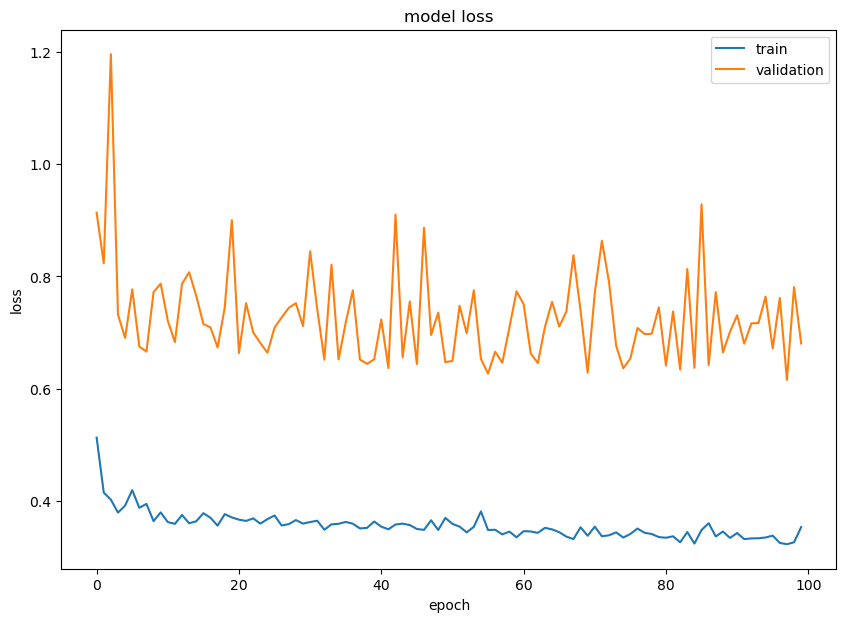

In [291]:
# summarize history for loss
plt.figure(figsize=(10, 7))
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='best')
plt.show()

# 8. Predicting the Trend 

In [292]:
from sklearn.metrics import accuracy_score
predict_trend = np.ones(len(X_test))
for i in range(X_test.shape[0]):
    predict_trend[i] = np.where(model.predict(
        np.expand_dims(X_test[i], axis=0))[0][0] > 0.5, 1, 0)
predict_trend = np.reshape(predict_trend, (1, -1)).tolist()[0]

acc = accuracy_score(list(y_test), list(predict_trend))

In [293]:
print("The Accuracy of the model on the test set is:", acc*100, '%')
print("\n\n\nThe Signals Predicted\n", list(predict_trend),sum(predict_trend))

The Accuracy of the model on the test set is: 67.0 %



The Signals Predicted
 [1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 

#  9. Visualizing and comparing the performance

In [294]:
market_returns = pd.Series(
    data.Close.shift(-1).iloc[-test_size:].pct_change().values)
strategy_returns = pd.Series(predict_trend*market_returns)
excess_return= strategy_returns - 0.05/252

In [295]:
def annualized_sharpe_ratio(returns, N=252):
    return np.sqrt(N) * returns.mean() / returns.std()

In [296]:
sharpe_test = annualized_sharpe_ratio(excess_return)
print(sharpe_test)

0.3094406983490025


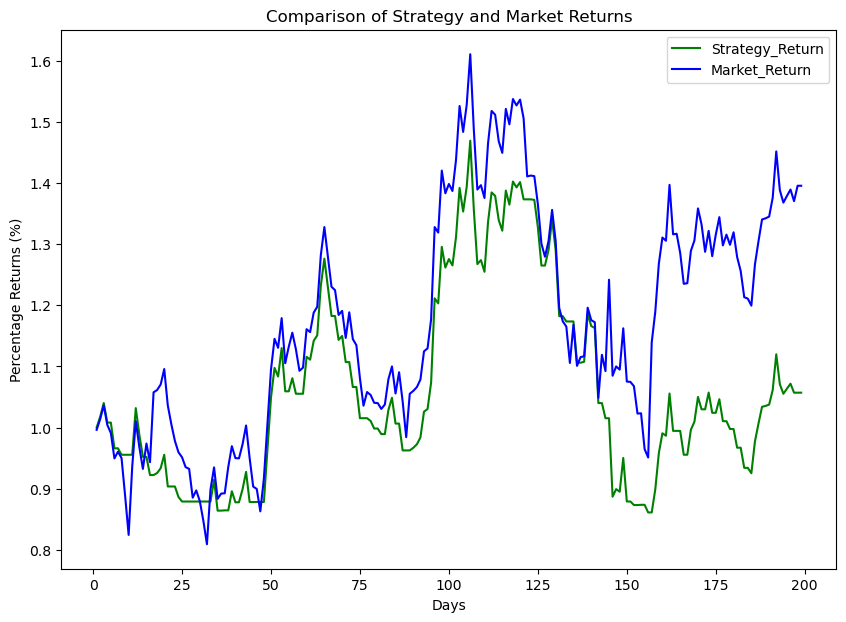

In [297]:
plt.figure(figsize=(10, 7))
plt.title('Comparison of Strategy and Market Returns')
plt.plot((strategy_returns+1).cumprod(), c='g')
plt.plot((market_returns+1).cumprod(), c='b')
plt.ylabel('Percentage Returns (%)')
plt.xlabel('Days')
plt.legend(['Strategy_Return', 'Market_Return'])
plt.show()

# 10. Calculate the Final Returns

In [298]:
final_return = (strategy_returns+1).cumprod()

In [299]:
# Use the model_from_json function to load the previously saved model
from keras.models import model_from_json
# Load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# Load weights of neurons for the model
loaded_model.load_weights('model.h5')
print("Loaded model from disk")

Loaded model from disk


In [300]:
final_return.tail(1)

199    1.057066
dtype: float64